
# Reconnaissance de visage







Ce bloc-notes examine l'utilisation de diverses bibliothèques d'apprentissage automatique et de science des données basées sur Python dans le but de créer un modèle d'apprentissage automatique capable d'effectuer la détection de visage sur l'image et la vidéo de notre webcam.

nous allons adopter l'approche suivante

1. Installé la bibliothèque Face_recognition
2. Importation des librairies
3. Convertion un objet JavaScript en image dans Opencv
4. Télécharger les photos
5. Faire la détection de visage


**Nous avons installé la bibliothèque Face_recognition**

In [1]:
!pip install face_recognition


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 1.1 MB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=11b7dadc57e131aae76f411b8e21d5b594fca6a8b9303eec59499f9846004704
  Stored in directory: /root/.cache/pip/wheels/b4/4b/8f/751e99d45f089bdf366a7d3e5066db3c2b84a62e4377f534d7
Successfully built face-recognition-models


**Nous importons les librairies**

In [2]:
# Importer tous les outils dont nous avons besoin

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [3]:
import face_recognition

**Fonction pour convertir un objet JavaScript en image dans Opencv**

In [4]:
# function 
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

**Nous téléchargeons les photos pour que vous appreniez à le reconnaître**

In [7]:
siwar_image = face_recognition.load_image_file("/content/sample_data/siwar.jpg")
siwar_face_encoding = face_recognition.face_encodings(siwar_image)[0]

ons_image = face_recognition.load_image_file("/content/sample_data/ons.png")
ons_face_encoding = face_recognition.face_encodings(ons_image)[0]

known_face_encodings = [
    siwar_face_encoding,
    ons_face_encoding
]
known_face_names = [
    "Siwar Gharbi",
    "Ons Jabeur"
]

In [8]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # 
  #
  #
  face_locations = face_recognition.face_locations(img)
  face_encodings = face_recognition.face_encodings(img, face_locations)
  # 
  #
  for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
    matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
    name = "Unknown"
    face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
    best_match_index = np.argmin(face_distances)
    if matches[best_match_index]:
      name = known_face_names[best_match_index]
    cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 255), 2)
    cv2.rectangle(img, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(img, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)
  # draw face bounding box on image
  #for (x,y,w,h) in faces:
      #img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


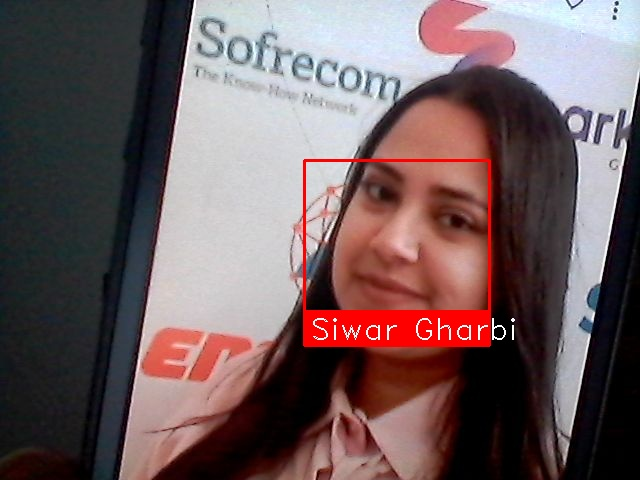

In [17]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))